In [18]:
def not_in_new_ride(a, b):
    ans=a
    # リストaからリストbに含まれている要素を取り除く
    for item in b:
        if item in a:
            ans.remove(item)
    return ans


# 24時間表示を分に変換
def calculate_minutes(time_str):
    # 時刻を時間と分に分割
    hours, mins = map(int, time_str.split(":"))
    
    # 9:00 を0分、20:00 を660分として計算
    start_time = 9 * 60  # 9:00を分単位に変換
    end_time = 20 * 60  # 20:00を分単位に変換
    
    # 入力された時刻を分単位に変換
    total_minutes = hours * 60 + mins
    
    # 24時間以上の場合は調整
    if total_minutes < start_time:
        total_minutes += 24 * 60
    
    # 開始時刻からの経過時間を計算
    elapsed_minutes = total_minutes - start_time
    
    return elapsed_minutes


# 分を24時間表示に変換
def calculate_time(minutes):
    # 9:00 を0分、20:00 を660分として計算
    start_time = 9 * 60  # 9:00を分単位に変換
    end_time = 20 * 60  # 20:00を分単位に変換
    
    total_minutes = start_time + minutes
    
    # 時間と分に変換
    hours = total_minutes // 60
    mins = total_minutes % 60
    
    # 24時間表記に変換
    if hours >= 24:
        hours -= 24
    
    # 時間と分を文字列に変換して返す
    return f"{hours:02d}:{mins:02d}"


def ride_printer(date, total_popularity, total_time, ride_lst, new_ride_lst, ride_time):
    print("-" * 40)
    print(f"~ {date} の待ち時間データによる乗車プラン ~")
    print("乗車時間　：　アトラクション名")
    for i in range(len(new_ride_lst)):
        print(f"{calculate_time(ride_time[i])}　： {attractions.get(new_ride_lst[i])}")
    print('トータル所要時間：',total_time)
    print('トータル満足度　：',total_popularity)
    print("-" * 40)
    if not(len(ride_lst)==len(new_ride_lst)):
        print("※全てのアトラクションを乗ることができません")
        print("プランから除外されたアトラクション")
        not_ride = not_in_new_ride(ride_lst, new_ride_lst)
        for i in not_ride:
            print(f"{i}　： {attractions.get(i)}")

In [19]:
import ast
from collections import Counter

# レビュー評価（popularity）
popularity = [476, 465, 473, 472, 480, 452, 461, 478]

def find_optimal_plan(date, attractions):
    # 入力のアトラクションの出現回数をカウント
    attraction_counts = Counter(attractions)
    
    # 日付でフィルタリング
    date_filtered_df = df[df['日付'] == date]
    
    # 指定アトラクションの出現回数が一致する行を抽出
    def matches_plan(optimal_plan):
        plan_counts = Counter(optimal_plan)
        return all(plan_counts.get(attraction, 0) >= count for attraction, count in attraction_counts.items())

    filtered_df = date_filtered_df[date_filtered_df['最適プラン'].apply(matches_plan)]
    
    if filtered_df.empty:
        print("指定された条件に合うプランは見つかりませんでした。")
        
        # '日付'が'median'のデータを参照
        median_df = df[df['日付'] == 'median']
        
        # 'median'のデータが存在する場合、トータル満足度が最大のプランを取得
        if not median_df.empty:
            max_satisfaction_plan = median_df.loc[median_df['トータル満足度'].idxmax()]
            print(f"参考データ（インデックス:{max_satisfaction_plan.name}, 日付:{max_satisfaction_plan['日付']}）")
        else:
            print("日付が'median'のデータは存在しません。すべてのデータから最適プランを選択します。")
            # 'median'がない場合は、全データから最適プランを選択
            max_satisfaction_plan = df.loc[df['トータル満足度'].idxmax()]
        
        # 足枷となっているアトラクションを除外して再検索
        excluded_attractions = []
        for attraction in attraction_counts:
            # 条件に合わないアトラクションを除外
            date_filtered_df_without_attraction = date_filtered_df[date_filtered_df['最適プラン'].apply(lambda x: attraction not in x)]
            if not date_filtered_df_without_attraction.empty:
                excluded_attractions.append(attraction)
                filtered_df = date_filtered_df_without_attraction[date_filtered_df_without_attraction['最適プラン'].apply(matches_plan)]
        
        if excluded_attractions:
            print(f"除外したアトラクション: {excluded_attractions}")
            if not filtered_df.empty:
                max_satisfaction_plan = filtered_df.loc[filtered_df['トータル満足度'].idxmax()]
            else:
                print("除外後も条件に合うプランは見つかりませんでした。")
        
    else:
        # トータル満足度が最大のプランを取得
        max_satisfaction_plan = filtered_df.loc[filtered_df['トータル満足度'].idxmax()]
    
    # 結果を出力
    print(f"参考データ：{max_satisfaction_plan['日付']}")
    print("最適プラン:", max_satisfaction_plan['最適プラン'])
    print("タイムスケジュール:", max_satisfaction_plan['タイムスケジュール'])
    print("トータル満足度:", max_satisfaction_plan['トータル満足度'])
    print("トータル所要時間:", max_satisfaction_plan['トータル所要時間'])
    print()
    
    # ここでride_printer関数を呼び出す
    ride_lst = max_satisfaction_plan['最適プラン']
    new_ride_lst = max_satisfaction_plan['最適プラン']
    
    # タイムスケジュールがリストとして渡されるように修正
    ride_time = max_satisfaction_plan['タイムスケジュール']
    
    # もしタイムスケジュールが文字列であれば、リストに変換
    if isinstance(ride_time, str):
        ride_time = ast.literal_eval(ride_time)  # 文字列をリストに変換
    
    # ride_timeがリスト形式であることを確認
    if not isinstance(ride_time, list):
        print("タイムスケジュールがリスト形式でありません。")
        return
    
    # 同じアトラクションが連続している場合、そのアトラクションを削除
    filtered_ride_lst = []
    filtered_ride_time = []
    
    for i in range(len(ride_lst)):
        if i == 0 or ride_lst[i] != ride_lst[i - 1]:
            filtered_ride_lst.append(ride_lst[i])
            filtered_ride_time.append(ride_time[i])

    # 結果の表示
    print("更新された最適プラン:", filtered_ride_lst)
    print("更新されたタイムスケジュール:", filtered_ride_time)
    
    # トータル満足度を再計算
    # filtered_ride_lst に基づいて、対応する popularity を取得
    total_popularity = sum([popularity[ride] for ride in filtered_ride_lst])
    
    # 再計算されたトータル満足度
    total_satisfaction = total_popularity
    
    print("再計算されたトータル満足度:", total_satisfaction)
    
    # 変数を準備してride_printer関数に渡す
    total_time = max_satisfaction_plan['トータル所要時間']
    
    ride_printer(max_satisfaction_plan['日付'], total_satisfaction, total_time, ride_lst, filtered_ride_lst, filtered_ride_time)

# 使用例
date_input = '2022-08-01'  # 予測したい日付
attractions_input = [0,1,2,3,4]  # 乗りたいアトラクション番号リスト
find_optimal_plan(date_input, attractions_input)


NameError: name 'df' is not defined

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import ast

def plot_waittime_and_optimal_plans(heatmap_csv_file, line_csv_file, start_time=9, end_time=20+45):
    """
    ヒートマップと折れ線グラフをプロットする関数。

    Parameters:
    - heatmap_csv_file (str): ヒートマップデータのCSVファイルパス。
    - line_csv_file (str): 折れ線グラフデータのCSVファイルパス。
    - attractions (list): アトラクションの名前のリスト。
    - start_time (int): プラン開始時間（デフォルトは09:00）。
    - end_time (int): プラン終了時間（デフォルトは20:45）。
    """
    # 日本語フォントを使用する
    plt.rcParams['font.family'] = 'IPAexGothic'
    
    #アトラクションの定義
    attractions = ['ソアリン', 'トイストーリーマニア', 'タワーオブテラー', 'センターオブジアース',
               'インディージョーンズ', 'レイジングスピリッツ', 'マジックランプシアター', 'タートルトーク']

    # ヒートマップデータの読み込み
    heatmap_df = pd.read_csv(heatmap_csv_file)
    heatmap_df = heatmap_df.loc[:, ~heatmap_df.columns.str.contains('^Unnamed')]
    heatmap_df = heatmap_df.apply(pd.to_numeric, errors='coerce')
    heatmap_data = heatmap_df.values
    heatmap_columns = heatmap_df.columns.astype(int)  # ヒートマップの列名を整数に変換

    # 折れ線グラフ用データの読み込み
    line_df = line_csv_file

    # プロットの準備
    plt.figure(figsize=(20, 10))

    # ヒートマップを表示
    norm = Normalize(vmin=np.nanmin(heatmap_data), vmax=np.nanmax(heatmap_data))
    cax = plt.imshow(heatmap_data, aspect='auto', cmap='coolwarm', norm=norm, interpolation='nearest', alpha=0.8)

    # x軸の設定
    time_range = range(start_time * 60, end_time + 1, 15)  # 15分刻み
    x_labels = [f"{t // 60:02d}:{t % 60:02d}" for t in time_range]

    # x軸に15分刻みのラベルを設定
    plt.xticks(range(len(x_labels)), x_labels, rotation=45, fontsize=8)

    # y軸の設定
    plt.yticks(range(len(attractions)), attractions, fontsize=10)

    # y軸の順番を逆にする
    plt.gca().invert_yaxis()

    # カラーバーの追加
    cbar = plt.colorbar(cax, label='混み具合')
    cbar.ax.tick_params(labelsize=10)

    # 折れ線グラフのデータ処理
    optimal_plans_list = [ast.literal_eval(plan) if isinstance(plan, str) else plan for plan in line_df["最適プラン"]]
    time_schedule_list = [ast.literal_eval(plan) if isinstance(plan, str) else plan for plan in line_df["タイムスケジュール"]]

    # 折れ線グラフのプロット（黒色で、点を少し大きくする）
    for i in range(len(optimal_plans_list)):
        adjusted_time_schedule = [np.where(heatmap_columns == tick)[0][0] for tick in time_schedule_list[i]]  # x軸位置を特定
        plt.plot(adjusted_time_schedule, optimal_plans_list[i], marker='o', linestyle='-', 
                 label=f'Data {i+1}', color='black', markersize=6)  # 黒色に変更、点のサイズを6に設定

    # グラフの詳細設定
    plt.xlabel("時間", fontsize=14)
    plt.ylabel("アトラクション", fontsize=14)
    plt.title("アトラクションの混む時間帯と最適プラン", fontsize=16)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)

    # レイアウト調整
    plt.tight_layout()
    plt.show()

# 使用例:
heatmap_csv_file = './waittime_heatmap_csv/2022-07-01_waittime.csv'
#line_csv_file = './automation_best_result_csv/re_best_results_2022-07-01_r10_t30_review.csv'


# 関数を呼び出してプロットを表示
#plot_waittime_and_optimal_plans(heatmap_csv_file, line_csv_file)


In [37]:
import pandas as pd
import ast
from collections import Counter

# レビュー評価（popularity）
popularity = [476, 465, 473, 472, 480, 452, 461, 478]

def find_optimal_plan(date, attractions):
    # データを読み込む
    df = pd.read_csv('updated_combined_data.csv')
    
    # 入力のアトラクションの出現回数をカウント
    attraction_counts = Counter(attractions)
    
    # 日付でフィルタリング
    date_filtered_df = df[df['日付'] == date].copy()
    
    # '最適プラン'列をリスト形式に変換
    date_filtered_df['最適プラン'] = date_filtered_df['最適プラン'].apply(ast.literal_eval)

    # 指定アトラクションの出現回数が一致する行を抽出
    def matches_plan(optimal_plan):
        plan_counts = Counter(optimal_plan)
        return all(plan_counts.get(attraction, 0) >= count for attraction, count in attraction_counts.items())

    filtered_df = date_filtered_df[date_filtered_df['最適プラン'].apply(matches_plan)]
    
    if filtered_df.empty:
        # 条件に一致するデータがない場合の処理
        print("指定された条件に合うプランは見つかりませんでした。")
        
        # '日付'が'median'のデータを参照
        median_df = df[df['日付'] == 'median']
        median_df['最適プラン'] = median_df['最適プラン'].apply(ast.literal_eval)

        if not median_df.empty:
            max_satisfaction_plan = median_df.loc[median_df['トータル満足度'].idxmax()]
        else:
            # 全データからトータル満足度が最大のプランを選択
            df['最適プラン'] = df['最適プラン'].apply(ast.literal_eval)
            max_satisfaction_plan = df.loc[df['トータル満足度'].idxmax()]
        
        # データフレームとして返す
        return pd.DataFrame([{
            '日付': max_satisfaction_plan['日付'],
            'トータル満足度': max_satisfaction_plan['トータル満足度'],
            'トータル所要時間': max_satisfaction_plan['トータル所要時間'],
            '予定プラン': attractions,
            '最適プラン': max_satisfaction_plan['最適プラン'],
            'タイムスケジュール': max_satisfaction_plan['タイムスケジュール']
        }])
    else:
        # トータル満足度が最大のプランを取得
        max_satisfaction_plan = filtered_df.loc[filtered_df['トータル満足度'].idxmax()]
        
        # データフレームとして返す
        return pd.DataFrame([{
            '日付': max_satisfaction_plan['日付'],
            'トータル満足度': max_satisfaction_plan['トータル満足度'],
            'トータル所要時間': max_satisfaction_plan['トータル所要時間'],
            '予定プラン': attractions,
            '最適プラン': max_satisfaction_plan['最適プラン'],
            'タイムスケジュール': max_satisfaction_plan['タイムスケジュール']
        }])

# 使用例
date_input = '2022-08-01'  # 予測したい日付
attractions_input = [0, 2, 3]  # 乗りたいアトラクション番号リスト

# 関数の呼び出しと結果表示
result_df = find_optimal_plan(date_input, attractions_input)
display(result_df)


,日付,トータル満足度,トータル所要時間,予定プラン,最適プラン,タイムスケジュール
0,2022-08-01,7087.0,672.0,"[0, 2, 3]","[4, 6, 4, 5, 3, 7, 4, 2, 4, 2, 5, 7, 4, 3, 0]","[0, 45, 90, 135, 180, 240, 300, 345, 405, 435,..."


,日付,トータル満足度,トータル所要時間,予定プラン,最適プラン,タイムスケジュール
0,2022-08-01,7087.0,672.0,"[0, 2, 3]","[4, 6, 4, 5, 3, 7, 4, 2, 4, 2, 5, 7, 4, 3, 0]","[0, 45, 90, 135, 180, 240, 300, 345, 405, 435,..."


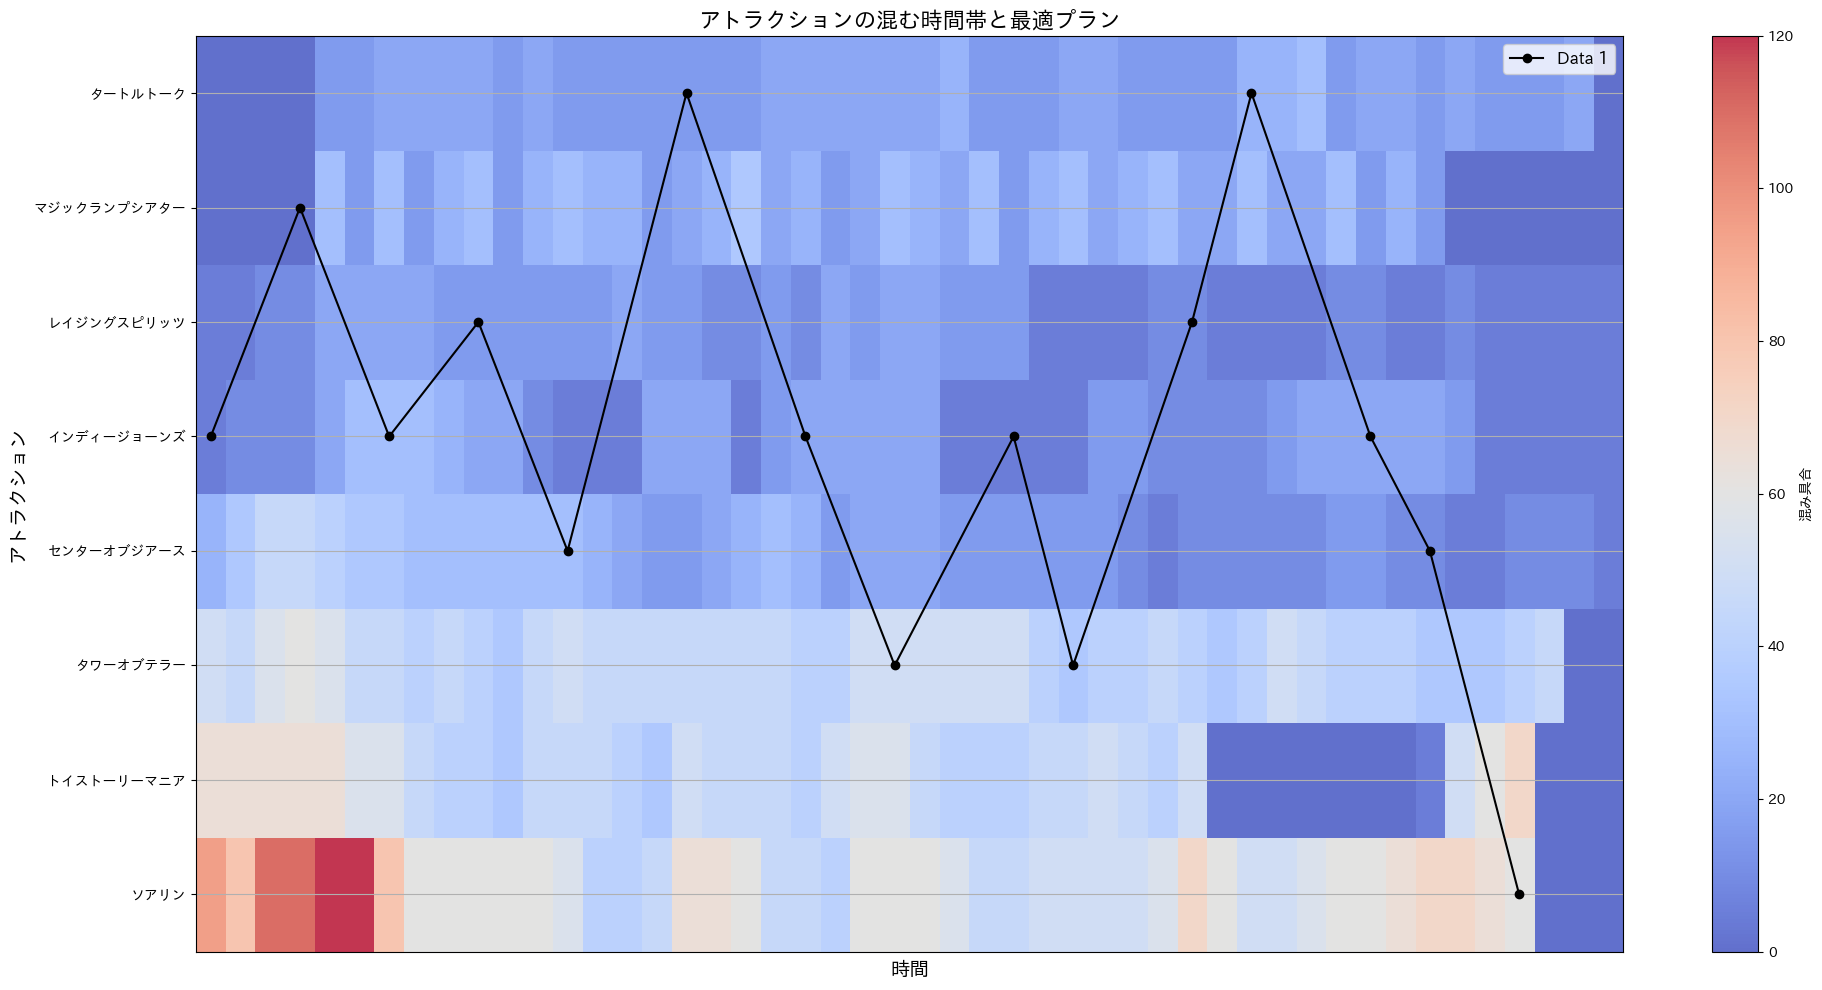

In [38]:
# 使用例
date_input = '2022-08-01'  # 予測したい日付
attractions_input = [0, 2, 3]  # 乗りたいアトラクション番号リスト

# 関数の呼び出しと結果表示
result_df = find_optimal_plan(date_input, attractions_input)
display(result_df)



# 関数を呼び出してプロットを表示
plot_waittime_and_optimal_plans(heatmap_csv_file, result_df)

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import ast
from collections import Counter

def not_in_new_ride(a, b):
    ans = a[:]
    for item in b:
        if item in a:
            ans.remove(item)
    return ans

def calculate_time(minutes):
    start_time = 9 * 60
    total_minutes = start_time + minutes
    hours = total_minutes // 60
    mins = total_minutes % 60
    if hours >= 24:
        hours -= 24
    return f"{hours:02d}:{mins:02d}"

def ride_printer(date, total_popularity, total_time, ride_lst, new_ride_lst, ride_time):
    attractions = {
    0: 'ソアリン',
    1: 'トイストーリーマニア',
    2: 'タワーオブテラー',
    3: 'センターオブジアース',
    4: 'インディージョーンズ',
    5: 'レイジングスピリッツ',
    6: 'マジックランプシアター',
    7: 'タートルトーク'
    }
    print("-" * 40)
    print(f"~ {date} の待ち時間データによる乗車プラン ~")
    print("乗車時間　：　アトラクション名")
    for i in range(len(new_ride_lst)):
        print(f"{calculate_time(ride_time[i])}　： {attractions.get(new_ride_lst[i])}")
    print('トータル所要時間：', total_time)
    print('トータル満足度　：', total_popularity)
    print("-" * 40)
    if len(new_ride_lst) < len(ride_lst):
        if len(ride_lst) != len(new_ride_lst):
            print("※全てのアトラクションを乗ることができません")
            print("プランから除外されたアトラクション")
            not_ride = not_in_new_ride(ride_lst, new_ride_lst)
            for i in not_ride:
                print(f"{i}　： {attractions.get(i)}")

def plot_waittime_and_optimal_plans(date_input, result_df):
    heatmap_csv_file = f'./waittime_heatmap_csv/{date_input}_waittime.csv'
    
    plt.rcParams['font.family'] = 'IPAexGothic'
    
    attractions = ['ソアリン', 'トイストーリーマニア', 'タワーオブテラー', 'センターオブジアース',
                   'インディージョーンズ', 'レイジングスピリッツ', 'マジックランプシアター', 'タートルトーク']

    heatmap_df = pd.read_csv(heatmap_csv_file)
    heatmap_df = heatmap_df.loc[:, ~heatmap_df.columns.str.contains('^Unnamed')]
    heatmap_data = heatmap_df.values
    heatmap_columns = heatmap_df.columns.astype(int)

    plt.figure(figsize=(20, 10))

    norm = Normalize(vmin=np.nanmin(heatmap_data), vmax=np.nanmax(heatmap_data))
    cax = plt.imshow(heatmap_data, aspect='auto', cmap='coolwarm', norm=norm, interpolation='nearest', alpha=0.8)

    time_range = range(9 * 60, 20 * 60 + 1, 15)
    x_labels = [f"{t // 60:02d}:{t % 60:02d}" for t in time_range]
    plt.xticks(range(len(x_labels)), x_labels, rotation=45, fontsize=8)
    plt.yticks(range(len(attractions)), attractions, fontsize=10)
    plt.gca().invert_yaxis()
    plt.colorbar(cax, label='混み具合').ax.tick_params(labelsize=10)

    optimal_plans_list = [ast.literal_eval(plan) if isinstance(plan, str) else plan for plan in result_df["最適プラン"]]
    time_schedule_list = [ast.literal_eval(plan) if isinstance(plan, str) else plan for plan in result_df["タイムスケジュール"]]

    for i in range(len(optimal_plans_list)):
        adjusted_time_schedule = [np.where(heatmap_columns == tick)[0][0] for tick in time_schedule_list[i]]
        plt.plot(adjusted_time_schedule, optimal_plans_list[i], marker='o', linestyle='-', 
                 label=f'Data {i+1}', color='black', markersize=6)

    plt.xlabel("時間", fontsize=14)
    plt.ylabel("アトラクション", fontsize=14)
    plt.title("アトラクションの混む時間帯と最適プラン", fontsize=16)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def find_and_plot_optimal_plan(date_input, attractions_input):
    # 日付を基にデータを取得
    result_df = find_optimal_plan(date_input, attractions_input)

    # 結果が空でない場合に処理を進める
    if not result_df.empty:
        # 各要素を取得1
        data1 = result_df.apply(lambda row: row.values.tolist(), axis=1).tolist()[0]
        data1 = [data1[0]] + [ast.literal_eval(item) if isinstance(item, str) else item for item in data1[1:]]
        date1 = data1[0]
        total_popularity1 = data1[1]
        total_time1 = data1[2]
        ride_lst1 = data1[3]
        new_ride_lst1 = data1[4]
        ride_time1 = data1[5]
        ride_printer(data1, total_popularity1, total_time1, ride_lst1, new_ride_lst1, ride_time1)
        
        # プロットを表示
        plot_waittime_and_optimal_plans(date_input, result_df)
    else:
        print(f"{date_input} の最適プランが見つかりませんでした。")


----------------------------------------
~ ['2022-07-03', 7560.0, 674.0, [0, 2, 3], [6, 5, 4, 7, 4, 3, 4, 3, 5, 2, 4, 0, 3, 4, 3, 4], [0, 45, 90, 120, 195, 240, 285, 315, 360, 405, 465, 495, 570, 600, 630, 660]] の待ち時間データによる乗車プラン ~
乗車時間　：　アトラクション名
09:00　： マジックランプシアター
09:45　： レイジングスピリッツ
10:30　： インディージョーンズ
11:00　： タートルトーク
12:15　： インディージョーンズ
13:00　： センターオブジアース
13:45　： インディージョーンズ
14:15　： センターオブジアース
15:00　： レイジングスピリッツ
15:45　： タワーオブテラー
16:45　： インディージョーンズ
17:15　： ソアリン
18:30　： センターオブジアース
19:00　： インディージョーンズ
19:30　： センターオブジアース
20:00　： インディージョーンズ
トータル所要時間： 674.0
トータル満足度　： 7560.0
----------------------------------------


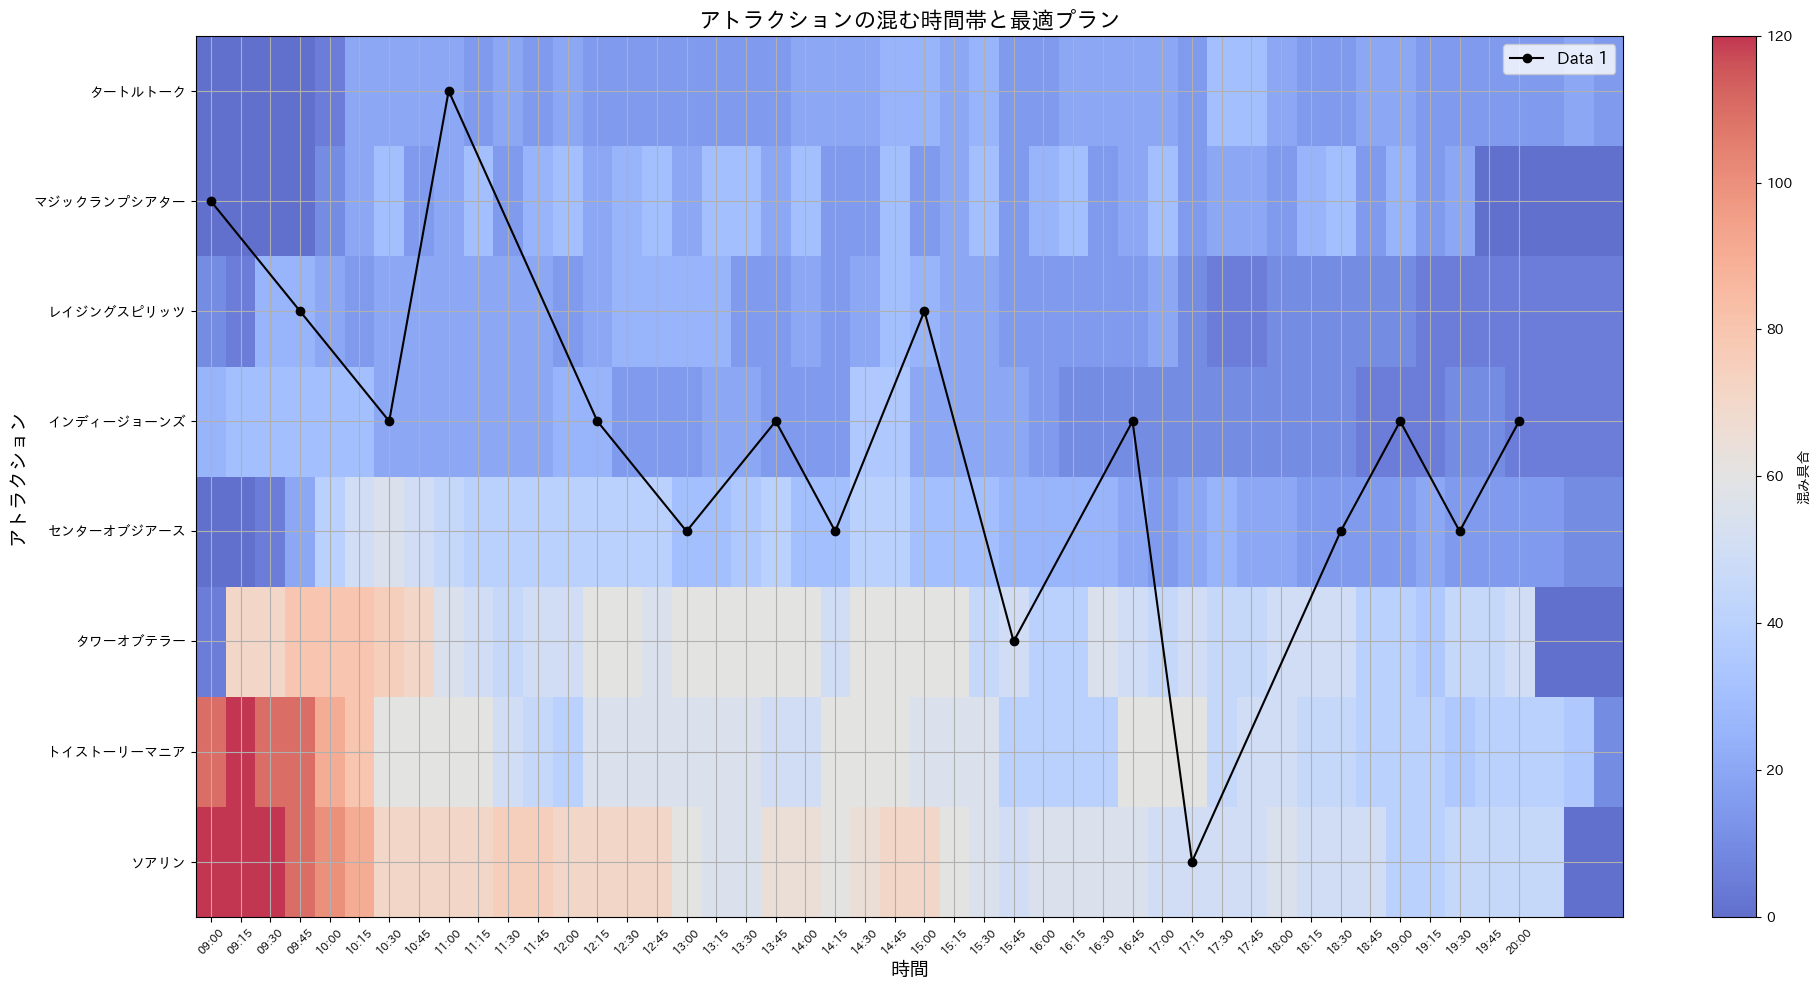

In [62]:
# 使用例
date_input = '2022-07-03'
attractions_input = [0, 2, 3]
find_and_plot_optimal_plan(date_input, attractions_input)